# import statements

In [1]:
import numpy as np
import pandas as pd
import math
import scipy
import sklearn
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, DotProduct
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kernels
from scipy.stats import spearmanr, pearsonr
import scipy.stats
import random

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt 
import seaborn as sns

# Data

In [2]:
Data_train = pd.read_csv('Train.csv')
Data_test = pd.read_csv('Test.csv')

X_train = Data_train['x']
X_train  = X_train.values.reshape((len(X_train), 1))
Y_train = Data_train['y']

X_test = Data_test['x']
X_test  = X_test.values.reshape((len(X_test), 1))
Y_test = Data_test['y']

# Covariance Estimation between Tasks 

In [138]:
def getPrediction(X, Y, X1):
    gp = GaussianProcessRegressor(kernel=kernels.DotProduct(), optimizer='fmin_l_bfgs_b' , alpha=1e-10, normalize_y=True, random_state=2404)
    gp.fit(X, Y)
    return gp.predict(X1)


def getFullCorrelation(X, T, Y, num_task):
    PredictionFunctions = np.zeros((len(X) , num_task ))
    Correlations = np.zeros((num_task, num_task))
    if (Correlations.shape[0] != num_task ):
        print(Correlations.shape[0], num_task)
        print('ERROR - NUMBER OF TASKS NOT MATCHING- getFULLCorr !!!')
        return 0
    
    for t in range(0, num_task):
        X_t = X[T == t]
        Y_t = Y[T == t]
        PredictionFunctions[:, t] = getPrediction(X_t, Y_t, X)
    for i in range(0, num_task):
        for j in range(i, num_task):
            Correlations[i, j] = np.cov(PredictionFunctions[:, i], PredictionFunctions[:, j])[0, 1]
            Correlations[j , i] = Correlations[i, j]
    return PredictionFunctions, Correlations

# Kernel functions to choose

In [4]:
def kernelfunction(a, b):
    if (kernel_number == 1):
        return  math.exp(-1*(np.dot(a-b , a-b) + 1)  )
    if (kernel_number == 2):
        return  np.dot(a, b) + 1
    if (kernel_number == 3):
        return  np.dot(a, b)*np.dot(a, b) + np.dot(a, b) + 1
    if (kernel_number == 4):
        return  np.dot(a, b)*np.dot(a, b)*np.dot(a, b) + np.dot(a, b)*np.dot(a, b) + np.dot(a, b)  + 1
    else:
        return 1

# KMeans Model for clustering with initialization

In [6]:
# from sklearn.cluster import KMeans

# def GetInitClusters(X, T, num_clusters):
#     init_clusters = np.zeros(num_clusters)
#     for i in range(num_clusters):
#         init_clusters[i] = np.mean(X[T == i])
#     return init_clusters

# def PredictKMeans(X, T, num_clusters):
#     init_clusters = getInitClusters(X, T, num_clusters)
#     KM = KMeans(n_clusters = num_clusters, init=init_clusters, algorithm='full')
#     KM.fit(X)
#     return KM.predict(X)

# def InitializeCluster(X, num_clusters):
#     KM = KMeans(n_clusters = num_clusters, init='k-means++', algorithm='full')
#     return KM.fit_predict(X)


# GMM Model for clustering with initialization

In [149]:
from sklearn.mixture import GaussianMixture

def GetMeanPrecisionWeigth(X, T, num_clusters):
    init_clusters_mean = np.zeros(num_clusters)
    init_clusters_Precision = np.zeros(num_clusters)
    init_clusters_Weigth = np.zeros(num_clusters)
    for i in range(num_clusters):
        init_clusters_mean[i] = np.mean(X[T == i])
        var = np.var(X[T == i])
        if (var == 0):
            var = var + sigma2
        var = var.reshape((len(X[0]) , len(X[0]) ))
#         var = var + sigma2
        init_clusters_Precision[i] = np.linalg.inv( var )
        init_clusters_Weigth[i] = len(X[T == i])/len(X)
    return init_clusters_mean, init_clusters_Precision, init_clusters_Weigth

def PredictGMM(X, T, num_clusters):
    num_clusters = len(set(T))
    mean, var, weigth = GetMeanPrecisionWeigth(X_train, T, num_clusters)
    mean  = mean.reshape((len(mean) , len(X_train[0])))
    var = var.reshape((len(var), 1, 1))
    gmm = GaussianMixture(n_components=num_clusters, means_init=mean, precisions_init=var, weights_init=weigth, random_state=2404)
    gmm.fit(X)
    return gmm.predict(X)
    

def initializeGMM(X, num_clusters):
    gmm = GaussianMixture(n_components=num_clusters, random_state=2404)
    gmm.fit(X)
    return gmm.predict(X)



# Multi-Task Gaussian Process

In [34]:
def MTGPPredict(x_new, t_new, X, T, alpha, Cn_inv, Correlations, sigma2):
    N = len(X)
    Knew = np.zeros(N)
    for i in range(N):
        Knew[i] = kernelfunction(x_new, X[i])*Correlations[t_new , T[i]]
    mean = np.dot(Knew, alpha)
    var1 = np.dot(np.dot(Knew, Cn_inv) , Knew)
    var =  kernelfunction(x_new, x_new)*Correlations[t_new , t_new] + sigma2 - var1
#     if(var < 0):
#         print('ERROR -- Variance less than 0' , x_new, t_new)
#         print('var1 = ', var1, 'first term = ', kernelfunction(x_new, x_new)*Correlations[t_new , t_new])
    return mean, var




def MTGP(X, T, Y, X_pred, T_pred, Correlations , sigma2 , num_task):
    if (Correlations.shape[0] != num_task):
        print(Correlations.shape[0], num_task)
        print('ERROR - NUMBER OF TASKS NOT MATCHING !!!')
        return 0
    N = len(X)    
    Cn = np.zeros((N, N))
    for i in range(0, N):
        for j in range(i, N):
            Cn[i, j] = kernelfunction(X[i],  X[j])*Correlations[T[i] , T[j]]
            Cn[j , i] = Cn[i , j]
    Cn = Cn + sigma2*np.identity(N)
    Cn_inv = np.linalg.inv(Cn)
    alpha = np.dot(Cn_inv, Y)
    Y_pred_mean = np.zeros(len(X_pred))
    Y_pred_var = np.zeros(len(X_pred))
    for i in range(len(X_pred)):
        Y_pred_mean[i], Y_pred_var[i] = MTGPPredict(X_pred[i] , T_pred[i] , X, T,alpha, Cn_inv, Correlations , sigma2 )
    return Y_pred_mean, Y_pred_var


# Plot functions and creating proper Tasks

In [7]:
def plotPoints(fr):
    sns.lmplot(x='input' , y='value', data=fr, hue='class',palette='hls', fit_reg=False,size= 5, aspect=5/3, legend_out=False,scatter_kws={"s": 70})
    plt.show()
    

def plotLine(fr):
    sns.pointplot(x='input' , y='value', data=fr, hue='class',palette='hls', fit_reg=False,size= 5, aspect=5/3, legend_out=False,scatter_kws={"s": 70})
    plt.show()


def MakeTask(T):
    dictionary = dict( zip(list(set(T)) , np.arange(len(set(T))))  )
    for i in range(len(T)):
        T[i] = dictionary[T[i]]
    T = T.astype('int')
    return T


# Hyper Parameters to optimize

# Update tasks accordingly

In [84]:
def getProb(Y_true, Y_pred_mean, Y_pred_var):
    prob = np.zeros(len(Y_true))
    for i in range(len(Y_true)):
        p = np.abs(Y_true[i] - Y_pred_mean[i])
        if (p != 0):
            prob[i] = 1/p 
        else:
            prob[i] = 1e+10
    return prob


def getPredInput(X, Y, num_task):
    X_pred = np.repeat(X, num_task)
    T_pred = np.repeat(np.repeat([np.arange(num_task)], len(X), axis=0), 1)
    Y_true = np.repeat(np.array(Y), num_task)
    return X_pred, T_pred, Y_true
    

def MTGPUpdate(X, T, Y, sigma2 ):
    T = MakeTask(T)
    num_task = len(set(T))
    PredictionFunctions, Correlations = getFullCorrelation(X, T, Y, num_task)
    X_pred, T_pred, Y_true = getPredInput(X, Y, num_task)
    Y_pred_mean, Y_pred_var = MTGP(X, T, Y, X_pred, T_pred, Correlations , sigma2 , num_task)
    Prob_Task = getProb(Y_true, Y_pred_mean, Y_pred_var)
    new_Tasks = np.zeros(len(X))
    for i in range(len(X)):
        new_Tasks[i] = np.argmax(Prob_Task[ i*num_task : (i+1)*num_task ])
    return MakeTask(new_Tasks)
                     

# MTGP iterate

In [197]:
def MTGPIterate(X, T, Y, num_iter, sigma2):
    for i in range(num_iter):
        T = MTGPUpdate(X, T, Y, sigma2 )
        num_task = len(set(T))
        T = PredictGMM(X=X, T=T, num_clusters=num_task )
#         print('Task vector  1 \t = ', T)
    return T
        
    

In [10]:
def getTaskPredData(X, T, X_pred):
    num_clusters = len(set(T))
    mean, var, weigth = GetMeanPrecisionWeigth(X, T, num_clusters)
    mean  = mean.reshape((len(mean) , len(X_train[0])))
    var = var.reshape((len(var), 1, 1))
    gmm = GaussianMixture(n_components=num_clusters, means_init=mean, precisions_init=var, weights_init=weigth)
    gmm.fit(X)
    return gmm.predict(X_pred)
    

In [136]:
num_task = 2
kernel_number = 4
sigma2 = 1e-13

T = initializeGMM(X=X_train, num_clusters=num_task)
T = MTGPIterate(X_train, T, Y_train, 5, sigma2)
T

Task vector  1 	 =  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Task vector  1 	 =  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Task vector  1 	 =  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Task vector  1 	 =  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Task vector  1 	 =  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [49]:
print(X_pred[9*3])
print(Y_pred_mean[9*3:10*3])
print(Y_pred_var[9*3 :10*3])
print(Y_train[9])


# p = scipy.stats.norm(Y_pred_mean[i], Y_pred_var[i]).pdf(Y_true[i])

4.039190554615448
[ 3.2890625  -1.01953125 -0.328125  ]
[0.80895833 0.11093859 0.3821884 ]
-0.7799656116444859


[0 0 0 0 2 2 2 2 2 1 1 1 1 1 1]
With Multi-Task 	 0.22167632850811672


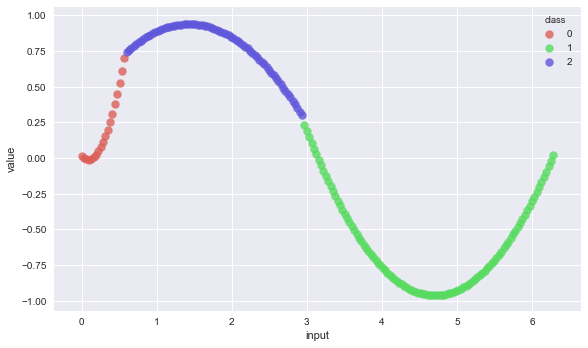

without Multi-Task 	 0.08522603423055086


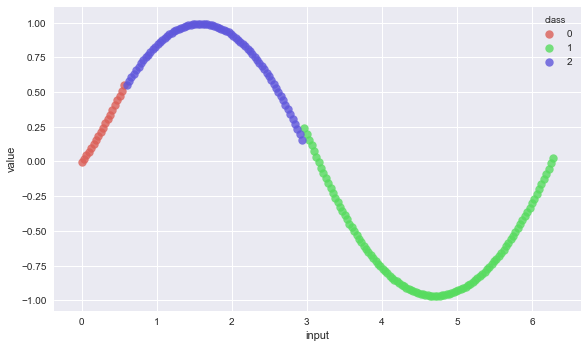

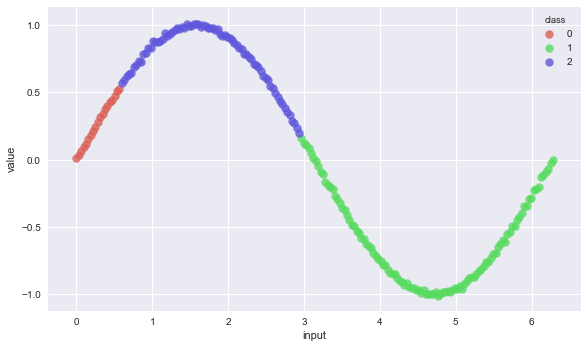

In [224]:
num_task = 3
kernel_number = 3
sigma2 = 1e-13
num_iter = 10

T = initializeGMM(X=X_train, num_clusters=num_task)
print(T)
T = MTGPIterate(X_train, T, Y_train, num_iter, sigma2)

num_task = len(set(T))
PredictionFunctions, Correlations = getFullCorrelation(X_train, T, Y_train, num_task)
T_test = getTaskPredData(X_train, T, X_test)

Y_pred_mean, Y_pred_var = MTGP(X_train, T, Y_train, X_test, T_test, Correlations , sigma2 , num_task)
diff = Y_pred_mean - Y_test
loss = math.sqrt(np.dot(diff, diff)/len(Y_train))
print('With Multi-Task \t',loss)



fr =pd.DataFrame({'class' : T_test, 'value': Y_pred_mean, 'input' : X_test[:, 0]})
plotPoints(fr)




A = np.identity(len(Correlations))
Correlations = np.multiply(A, Correlations)
Y_pred_mean, Y_pred_var = MTGP(X_train, T, Y_train, X_test, T_test, Correlations , sigma2 , num_task)
diff = Y_pred_mean - Y_test
loss = math.sqrt(np.dot(diff, diff)/len(Y_train))
print('without Multi-Task \t', loss)


fr =pd.DataFrame({'class' : T_test, 'value': Y_pred_mean, 'input' : X_test[:, 0]})
plotPoints(fr)

fr =pd.DataFrame({'class' : T_test, 'value': Y_test, 'input' : X_test[:, 0]})
plotPoints(fr)



num_task = 3
kernel_number = 2
sigma2 = 1e-13
num_iter = 10
0.15714873425409404
-----------------------



# Train and Testing 

In [19]:
num_task = 5
num_iter = 10
sigma2 = 1e-13
kernel_number = 3


def TrainPredict(X_train, Y_train, X_test, Y_test, num_task, num_iter, sigma2):
    T = initializeGMM(X=X_train, num_clusters=num_task)
    T = MTGPIterate(X_train, T, Y_train, num_iter, sigma2)
    T = MakeTask(T)
    num_task = len(set(T))
    PredictionFunctions, Correlations = getFullCorrelation(X_train, T, Y_train, num_task)
    T_test = getTaskPredData(X_train, T, X_test)
    Y_pred_mean, Y_pred_var = MTGP(X_train, T, Y_train, X_test, T_test, Correlations , sigma2 , num_task)
    diff = Y_pred_mean - Y_test
    loss = math.sqrt( np.dot(diff, diff)/len(diff) )
#     print('num_task = ' , num_task, 'sigma2 = ', sigma2, 'loss = ' ,loss)
    return loss

    

for kernel_number in (1, 2, 3, 4):
    for  num_task in (1, 2, 3, 4, 5):
        min_loss = 1000000
        for sigma2 in (1e-03, 1e-04, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15, 1e-16, 1e-17):
            loss = TrainPredict(X_train, Y_train, X_test, Y_test, num_task, num_iter, sigma2)
            if (loss < min_loss):
                min_loss = loss
        print(num_task, ' kernel_number\t' , kernel_number , '\tloss = ' , min_loss)
        
    
    

In [204]:
A = np.identity(2)
B = [[2, 3], [3, 4]]
np.multiply(A, B)

array([[2., 0.],
       [0., 4.]])